In [1]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import bitis as bt


df = bt.datasets.tissue_dataset()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tissue Matrix          56 non-null     object 
 1   Density                56 non-null     float64
 2   Elongation             56 non-null     float64
 3   Orientation            56 non-null     float64
 4   Compactness            56 non-null     float64
 5   Structural_anisotropy  56 non-null     float64
 6   Complexity             56 non-null     float64
 7   Tissue size            56 non-null     object 
dtypes: float64(6), object(2)
memory usage: 3.6+ KB


(4, 8)


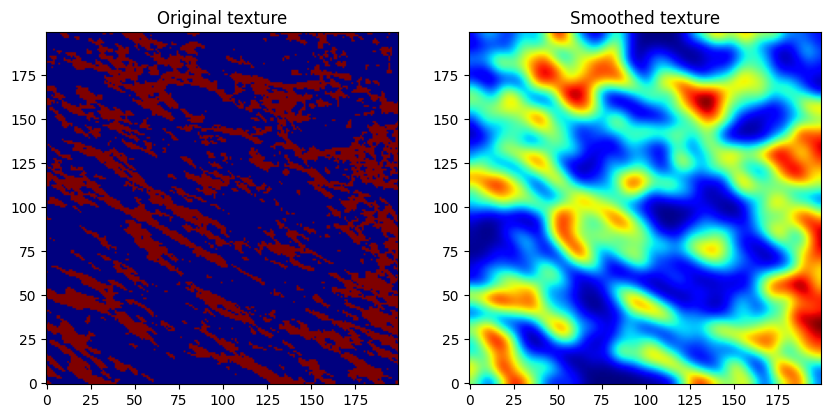

In [3]:
from pathlib import Path
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


# Filter the dataset to extract one specific texture that meets the criteria:
filtered_df = df[(df['Density'].between(0.3, 0.35)) &
                 (df['Elongation'] > 2.5)]

print(filtered_df.shape)
texture = filtered_df["Tissue Matrix"].iloc[0]

# 1 - healthy tissue, 2 - fibrosis
texture = np.where(texture == 0, 1, 2).astype(np.float32)
texture_smoothed = gaussian_filter(texture, sigma=5)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(texture, cmap='jet', origin='lower')
axs[0].set_title('Original texture')
axs[1].imshow(texture_smoothed, cmap='jet', origin='lower')
axs[1].set_title('Smoothed texture')
plt.show()

100%|██████████| 40000/40000 [00:09<00:00, 4203.67it/s]


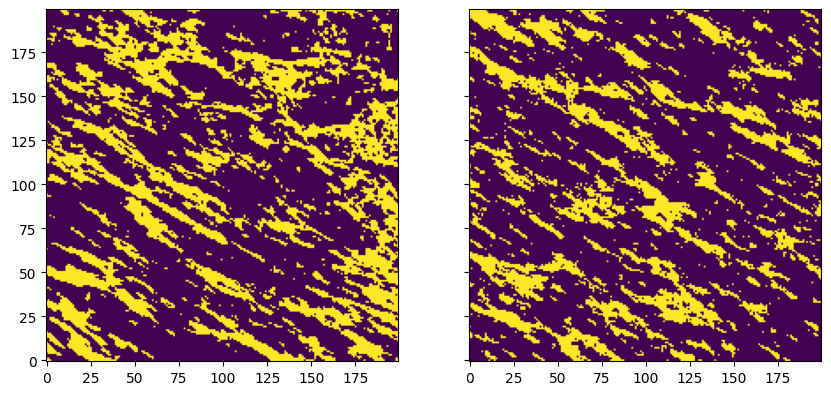

In [8]:
import bitis as bt

training_tex = texture[:, :].astype(np.float32)
simulation_tex = np.zeros_like(training_tex)
simulation = bt.AdaptiveSampling(simulation_tex,
                                 training_tex,
                                 max_known_pixels=30,
                                 min_known_pixels=5,
                                 max_template_size=50,
                                 min_template_size=5,
                                 n_candidates=1)

simulated_tex = simulation.run()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(training_tex, origin='lower')
ax[1].imshow(simulated_tex, origin='lower')
plt.show()

100%|██████████| 40000/40000 [00:13<00:00, 2870.50it/s]


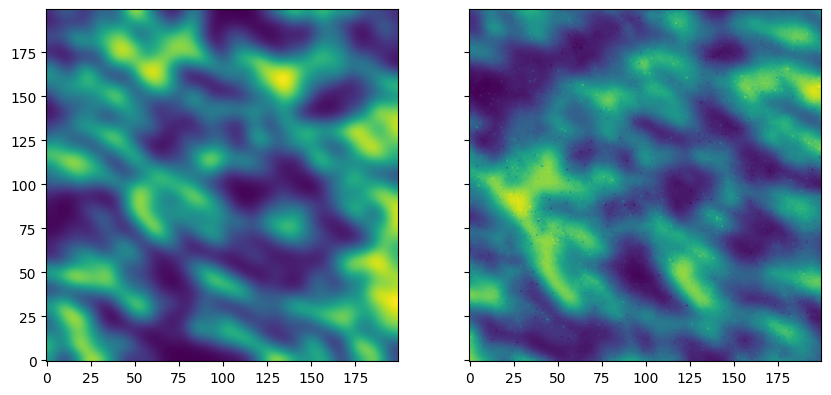

In [9]:
max_known_pixels = 30
max_template_size = 40
min_template_size = 3
num_of_candidates = 2
min_known_pixels = 1

training_image = texture_smoothed

simulation_tex = np.zeros_like(training_image)
simulation = bt.Simulation()
simulation.path_builder = bt.RandomSimulationPathBuilder(simulation_tex)
simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
simulation.template_matching = bt.ContinuousVariableMatching(training_image,
                                                             num_of_candidates,
                                                             min_known_pixels)
simulated_tex = simulation.run()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(training_image, origin='lower')
ax[1].imshow(simulated_tex, origin='lower')
plt.show()

100%|██████████| 40000/40000 [00:11<00:00, 3382.75it/s]


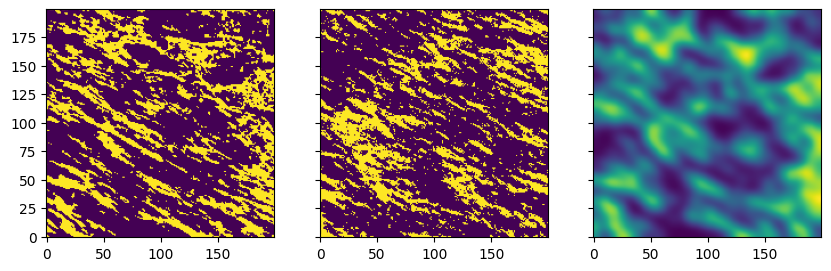

In [10]:
max_known_pixels = 30
max_template_size = 40
min_template_size = 3
num_of_candidates = 2
min_known_pixels = 1

joint_simulated_image = simulated_tex.copy()
joint_training_image = training_image.copy()

training_image = texture.copy()

max_known_pixels = 30
max_template_size = 40
min_template_size = 3
n_candidates = 3
min_known_pixels = 1

simulation_tex = np.zeros_like(training_image)
multi_var_simulation = bt.Simulation()
multi_var_simulation.path_builder = bt.MultivariateSimulationPathBuilder(simulation_tex)
multi_var_simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                                   max_known_pixels,
                                                                   max_template_size,
                                                                   min_template_size)
multi_var_simulation.template_matching = bt.MultivariateVariableMatching(training_image,
                                                                         joint_training_image,
                                                                         joint_simulated_image,
                                                                         n_candidates,
                                                                         min_known_pixels)

simulated_tex = multi_var_simulation.run()

fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax[0].imshow(training_image, origin='lower')
ax[1].imshow(simulated_tex, origin='lower')
ax[2].imshow(joint_training_image, origin='lower')
plt.show()